# Recommendation Systems for Amazon Books (total 100pts + 10pts bonus)


In [ ]:
!pip install -q scikit-surprise

     |████████████████████████████████| 11.8MB 7.9MB/s 


In [ ]:
import pandas as pd
import numpy as np
import random
import csv

## ***Overview:***


In this project, you will build  recommemder systems using different approaches.

We will be using the Amazon Review data:
https://nijianmo.github.io/amazon/index.html

Note this is a fairly large dataset. We will use the Book review from `"Small" subsets for experimentation` and use `ratings only(51,311,621 ratings)` dataset, which is listed at the last section of the document. However you are required to read through the entire document before proceeding.

## Task one: Data ingest (10pts)

Please download the dataset first. If you expect you are going to work on this dataset for a period of several days (which is expected), you can mount on your google drive by clicking the folder icon then Google drive icon (the third one on top after clicking the folder icon) from left menu of colab, your drive will be mounted as "/content/drive/MyDrive". Now you can use linux copy command (reference cheatsheet or search for it) to copy the file to your drive. Next time you can just copy it back when you start a new colab session. This dataset contains book reviews from Amazon, with below columns:

*  User ID
*  Book ID
*  Rating (1 to 5)
*  Date they gave the ratings(unix timestamp, google for how to convert to datetime object. For validation, 1123804800 should be converted to 2005-08-12 00:00:00)

Because of the large data size, you want to create a small dataset using first 10,000 lines (reference the spark/docker tutorial and project guide for doing this), and play with this file until your code runs ok, then you switch to the full size dataset. Let's assume the small dataset is `books10m.csv`


In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')

cp ./drive/MyDrive/Books.csv Books.csv
'''

Mounted at /content/drive


In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Books.csv

--2021-05-12 12:07:25--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Books.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2140933459 (2.0G) [application/octet-stream]
Saving to: ‘Books.csv’

Books.csv           100%[===================>]   1.99G  79.4MB/s    in 24s     

2021-05-12 12:07:49 (85.8 MB/s) - ‘Books.csv’ saved [2140933459/2140933459]



In [ ]:
'''
!head -n 10000 Books.csv > books10m.csv

custom_date_parser = lambda x: pd.to_datetime(x, unit='s')
filename = 'books10m.csv'
books = pd.read_csv(filename, names = ['user_id', 'book_id', 'rating', 'date'], parse_dates=['date'], date_parser=custom_date_parser)

books
'''

## Task Two:  Reservoir Sampling (you can do this step in the last) (15pts)

Write a function `Reservoir_Sampling`:
```python
def Reservoir_Sampling(infile_name, outfile_name, k):
    # your code
```
It takes the input file name `infile_name`, which in this case is "Books.csv" that you downloaded and sample k lines. We use the input file to mimic streaming data by read it line by line: you want to uniformly sample from the streaming data which is effectively infinitely long, you want to make sure that at any moment, for the `n` data points you received so far, you keep `k` points that are uniformly sampled from these `n` points. Note `n` is growing over time and is endlessly growing.

We will be implementing an algorithm called Reservoir Sampling to do this, which

- if `n<=k` we keep all incoming data points from the stream in a list `KEEP`;
- when a new data point that is $n^{th}$ comes, if n>k, roll a dice that gives the new data point a probability of 1/n to be appended to `KEEP`;
    - if the $n^{th}$ new data point is to be appended to `KEEP` and if doing so would cause `len(KEEP)==k+1`, we roll another dice to randomly pick a point from `KEEP` (before appending) to throw away, each data point in `KEEP` has equal probability to be discarded.

The idea is to read the input file line by line and use "Reservoir Sampling" algorithm to keep `K` lines. When all lines from the input file is processed, write the `KEEP` to output file `outfile_name`. You will be building recommender system using this randomly sampled file.

This project asks k=10,000,000 (10million, you can use a smaller number before submission):

Following code should create the sampled file `books10m.csv' with 10m lines.
```python
Reservoir_Sampling('Books.csv', 'books10m.csv', 10000000)
```

If you don't know how to read text file line by line, consult python cheatsheet or search for it. 

In [ ]:
def Reservoir_Sampling(infile_name, outfile_name, k):
  with open(infile_name) as file_object:
    lines = file_object.readlines()
  KEEP = []
  n = 0
  for line in lines:
    if n < k:
      KEEP.append(line)
    else:
      if random.randint(1, n) <= k:
        index = random.randint(0, k - 1)
        KEEP[index] = line
    n += 1
  
  with open(outfile_name, 'w') as result_file:
    for l in KEEP:
      result_file.write(l)
  

In [ ]:
# DO NOT MODIFY THIS CELL
Reservoir_Sampling('Books.csv', 'books10m.csv', 10000000)

In [ ]:
custom_date_parser = lambda x: pd.to_datetime(x, unit='s')
filename = 'books10m.csv'
books = pd.read_csv(filename, names = ['user_id', 'book_id', 'rating', 'date'], parse_dates=['date'], date_parser=custom_date_parser)

books

,user_id,book_id,rating,date
0,0001713353,A1C6M8LCIX4M6M,5.0,2005-08-12
1,0988185113,A3L73HT5J32G98,5.0,2013-06-21
2,1479170933,A28BIBPQ1JZ1H9,5.0,2015-07-30
3,0848733959,A3DQ5GS0JBAO2Z,5.0,2011-11-18
4,1101966319,A1WKQ94M45D8MG,4.0,2018-07-24
...,...,...,...,...
9999995,0983952418,A8RHGPPRXQ2TM,4.0,2015-03-22
9999996,1592701914,A2PMTP1Q51FMP,5.0,2017-01-23
9999997,0445408499,A2MB5XC5QP3WBW,4.0,2002-05-23
9999998,0399137378,A345M2XGCI9AAN,5.0,2010-12-21


## Task Three: Data Exploration (15pts)

Please explore your data with appropriate plots and tables/printouts: total counts, value/counts distributions of user-item interactions etc.

In [ ]:
rating_count = books.value_counts('rating').sort_index()
book_count = books.value_counts('book_id')
user_count = books.value_counts('user_id')

#### Rating

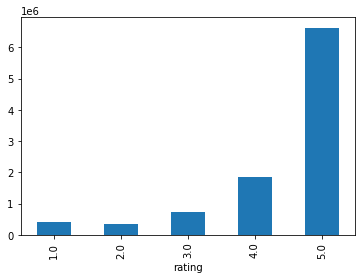

In [ ]:
rating_count.plot.bar()

The number of ratings increases as rating increases, with the exception of rating equals 2. This shows most books are rated as 5, and very fews books have rate less and equal to 3.

In [ ]:
books.rating.describe()

count    1.000000e+07
mean     4.393448e+00
std      1.044918e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

The mean rating is 4.39, the median is 5 as shown in bar plot.

In [ ]:
books.groupby('book_id')['rating'].mean().mean()

4.411311926644094

The average rating of a book is 4.41

In [ ]:
books.groupby('user_id')['rating'].mean().mean()

4.3974307843357465

The average rating a user gives is 4.40

#### Book

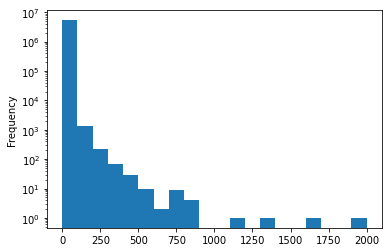

In [ ]:
book_count.plot.hist(log = True, bins = range(0, 2100, 100))

Note that this plot is in log scale. Most books have few ratings; only around 1000 books have more than 100 ratings.

In [ ]:
book_count.describe()

count    5.344591e+06
mean     1.871051e+00
std      4.809799e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.922000e+03
dtype: float64

On average, a book has been rated 1.87 times.

In [ ]:
book_count_freq = book_count.value_counts().sort_index()
book_count_rfreq = (book_count_freq / sum(book_count_freq)).round(2)
book_count_rfreq.head(10)

1     0.72
2     0.15
3     0.05
4     0.03
5     0.01
6     0.01
7     0.01
8     0.00
9     0.00
10    0.00
dtype: float64

Let's look in detail, 72% of books have only been rated once, 15% of books have been rated twice.

In [ ]:
book_count_freq.tail()

863     1
1140    1
1379    1
1679    1
1922    1
dtype: int64

The most reviewed book has 1922 ratings.

#### User

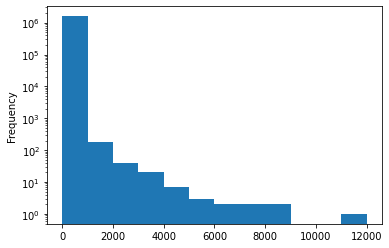

In [ ]:
user_count.plot.hist(log = True, bins = range(0, 13000, 1000))

Note that this plot is in log scale. Most users have few ratings; only around 100 users have more than 1000 ratings.

In [ ]:
user_count.describe()

count    1.587456e+06
mean     6.299387e+00
std      3.802877e+01
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      1.152800e+04
dtype: float64

On average, a user has rated 6.30 books.

In [ ]:
user_count_freq = user_count.value_counts().sort_index()
user_count_rfreq = (user_count_freq / sum(user_count_freq)).round(2)
user_count_rfreq.head(10)

1     0.45
2     0.17
3     0.09
4     0.06
5     0.04
6     0.03
7     0.02
8     0.02
9     0.01
10    0.01
dtype: float64

Let's look in detail, 45% of users have only rated once, 17% of users have rated twice.

In [ ]:
user_count_freq.tail()

7073     1
7355     1
8571     1
8729     1
11528    1
dtype: int64

The most active user rates 11528 books.

## Task Four: Triming your data (15pts)

Since the dataset is pretty sparse. Please trim down the size of the data by:

- removing data before '2000-01-01 00:00:00', let's focus on more recent data

- removing books that received less than or equal 2 ratings

- removing users that reviewed less than or equal `m` books, where m is 80% quantile of user ratings count (i.e., variable to consider for quantile is the total count of ratings by each user) -- we keep only the top 20% user who are active in rating books.

Print out the statistics before and after triming for the total users and books and dataframe shape.

In [ ]:
print('before triming:')
print('number of books:', books.book_id.nunique(), '\nnumber of users:', books.user_id.nunique())
print('mean rating:', books.rating.mean(), '\nmedian rating:', books.rating.median())
print('rating distribution:')
books.rating.value_counts()

before triming:
number of books: 5344406 
number of users: 1587897
mean rating: 4.3932903 
median rating: 5.0
rating distribution:


5.0    6622367
4.0    1863096
3.0     747008
1.0     407394
2.0     360133
0.0          2
Name: rating, dtype: int64

In [ ]:
def trim(books):
  books = books[books['date'] >= '2010-01-01']

  book_count = books.book_id.value_counts()
  book_keep = book_count[book_count > 2]
  del book_count

  user_count = books.user_id.value_counts()
  user_keep = user_count[user_count > user_count.quantile(0.8)]
  del user_count
  
  books = books.merge(book_keep.rename('book'), left_on = 'book_id', right_index = True)
  del book_keep
  books = books.merge(user_keep.rename('user'), left_on = 'user_id', right_index = True)
  del user_keep

  return books

In [ ]:
books = trim(books)
books

,user_id,book_id,rating,date,book,user
1,0988185113,A3L73HT5J32G98,5.0,2013-06-21,18,10
7100964,0988185113,A3CQLQXVXOKLWL,3.0,2014-10-18,176,10
8474344,0988185113,A14XEJQEVKQLFH,5.0,2013-11-09,16,10
8510305,0988185113,A2JL5XS80EXSYB,5.0,2013-09-26,17,10
8146174,0988185113,A1FCVX9J52FFDO,5.0,2014-01-04,17,10
...,...,...,...,...,...,...
9633104,1935961462,A1QSYM4CUUFIXG,5.0,2013-11-19,4,6
9407328,1883206561,A16MQLZ96ZRADB,3.0,2012-03-31,4,6
9544737,1599821419,A1AM5GJH4EWHFC,4.0,2015-10-03,3,21
9505751,0321714776,ARIZELVGMVMW4,5.0,2013-08-01,3,6


In [ ]:
print('after triming:')
print('rows of data:', len(books))
print('number of books:', books.book_id.nunique(), '\nnumber of users:', books.user_id.nunique())
print('mean rating:', books.rating.mean(), '\nmedian rating:', books.rating.median())
print('rating distribution:')
books.rating.value_counts()

after triming:
rows of data: 3260044
number of books: 628404 
number of users: 256029
mean rating: 4.394123208153019 
median rating: 5.0
rating distribution:


5.0    2045511
4.0     733246
3.0     285644
2.0     111922
1.0      83720
0.0          1
Name: rating, dtype: int64

## Task Five: fit the model using the data. (20pts)

You should prepare your data for surprise library. Check document [here](https://surprise.readthedocs.io/en/stable/getting_started.html#use-a-custom-dataset) for how to read data from pandas data frame or from text file--you need to make sure your data frame or text file follow the required format as shown in the example code.

Then you should run code below, it takes less than 30min to finish for 'books10m.csv' data set after trimming. Basically it fits the data with latent factor decomposition (SVD), that factorize the user-item matrix into latent factor matrices P and Q. The dimension (number of latent features) of P and Q is specified by `n_factors`, which defaults to 100. See `?SVD` for more options and details. The code chunk would run the SVD 3 times (called k-fold cross validation, k=3 here), each with a random split of the data into 20% for test, 80% for training, and RMS error is printed out for each of 3 runs.

You should run the code with default call to `SVD()`, as well as in n_factors=50 and n_factors = 150, respectively. Compare the RMSE and running time.

In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader


from surprise import accuracy
from surprise.model_selection import KFold

In [ ]:
# Your code to prepare data
reader = Reader()

# Load the dataset w 
data = Dataset.load_from_df(books[['user_id','book_id','rating']], reader)

#### Run code chunk below as is after data is loaded.

In [ ]:
# define a cross-validation iterator
kf = KFold(n_splits=3)

algo = SVD()

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.8879
RMSE: 0.8886
RMSE: 0.8893


Output example:
```
RMSE: 0.9793
RMSE: 0.9796
RMSE: 0.9783
```

#### Copy code chunk above and use n_factors=50 for `SVD` call, then rerun.

In [ ]:
# define a cross-validation iterator
kf = KFold(n_splits=3)

algo = SVD(n_factors = 50)

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.8840
RMSE: 0.8840
RMSE: 0.8867


#### Copy code chunk above and use n_factors=150 for `SVD` call, then rerun.

In [ ]:
# define a cross-validation iterator
kf = KFold(n_splits=3)

algo = SVD(n_factors = 150)

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.8911
RMSE: 0.8910
RMSE: 0.8950


## Task Six: use the model for recommendation (15pts)

Use any one of the users from above trainset in the last code chunk (n_factors=150) to predict his/her book ratings. Print the top 10 books that he did not rate but would rate highest as recommended books.

You can reference document here:
https://surprise.readthedocs.io/en/stable/getting_started.html#train-on-a-whole-trainset-and-the-predict-method

Read the example code about how to do this. Please note it doesn't matter if 

```python
algo = KNNBasic()
```
or
```python
algo = SVD()
```

The syntax for prediction is the same.

- Raw id: id in data frame
- Inner id: assigned unique integer by Surprise, range(0, len)
- uid: user id
- iid: item id (book id）

predict():
- use raw id

trainset:
- contain inner id

to_raw_uid(), to_raw_iid():
- convert inner to raw

In [ ]:
algo = SVD()
algo.fit(trainset)

In [ ]:
user_id = trainset.to_raw_uid(0)
rated_books = trainset.ur[0]
rated_books = [i[0] for i in rated_books]
new_books = [b for b in trainset.all_items() if b not in rated_books]

predictions = []
for b in new_books:
  book_id = trainset.to_raw_iid(b)
  est = algo.predict(str(user_id), book_id).est
  predictions.append([book_id, est])

In [ ]:
predictions = pd.DataFrame(predictions, columns = ['book_id', 'rating'])
predictions.sort_values('rating', ascending = False).head(10)

,book_id,rating
156659,A115DNKESW9EAE,4.523907
12102,A39M153PSJWSVR,4.511583
90879,A22VTPKPQC0LW2,4.509924
14387,AEIU24QQVHUM2,4.500793
35474,A3VO2CKSPF8EHP,4.466795
190272,A3D3ATAUKEUXGA,4.462122
104644,AGFJ3DPS5ZXAW,4.450816
61008,A3H8GNI7FAMGWE,4.447807
174118,A1CIZXC51NKLSR,4.447380
38531,ACNA2DX8FTGWG,4.444844


## Task Seven: build the SVD from scratch. (20pts, including 10pts for bonus)


Reference article [here](https://albertauyeung.github.io/2017/04/23/python-matrix-factorization.html) and notebook [here](https://albertauyeung.github.io/2017/04/23/python-matrix-factorization.html) for doing SVD/matrix factorization from scratch without using surprise. You can copy his code but you must use our sampled data from Books.csv, but you can furth reduce the data size to be 10% of the rows.

You want to play with his code first and after you understand it you put in our dataset.

You can use the train/test split function from surprise to do train/test split:
```python
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.25)

# train your copied model with our data
```
Note: you have to figure out how to convert trainset and testset objects into the data format for the MF object. You can use python's `dir()` function to see methods/attributes of trainset, testset to explore.

Then you call the `get_rating` method in `MF` class to predict ratings from testset, then you compute RMSE using the ratings from testset as ground truth.



Problems and Solutions:
- 
  - Since ndarray does not have label/index for row and column, I will use the inner id generate by testset (so id corrsponds to index). I can get raw id back by using to_raw_iid and to_raw_uid if needed.
  - all_ratings gives inner id; build_testset() gives raw id.
- 
  - I randomly sample 10% of trimmed data (1st sample). It has around 300000 rows of data, with 200000 books and 100000 users. 
  - RAM exceeds its limit when I create a ndarray with np.zero().
- 
  - Thus, I want to reduce the data more by applying another interpretation. I randomly sample 1M data from the original dataset (which is 10% of the 10M), then trim the data like what I do before (2nd sample). This reduce data to 70000 rows, with 24000 books and 35000 users. 
  - This time, the ndarray is created successfully, but RAM exceeds its limit after running mf.train() for 5 minutes.
- 
  - I get a suggestion from Shudi, which is to use csr_matrix (a sparse matrix). This can lower the memory used.
  - csr_matrix also has shape and nonzero, so no need to change. However, the part for calculating mean does not work. So, I research a way for csr_matrix.
  - It takes a long time for the function to excute; I wait for 20 minutes and do not get the result. Shudi says that he tries a hour but still does not get the result.
  - I find that it takes a long time for the line with linear combination (creating self.samples). I think it is the cause of the problem, because even when I reduce data to 70000 rows, there are still 24000 books and 35000 users, which means it needs to excute nearly 1 billion if-statement. Since the origianl data (testset.all_ratings()) is what self.samples intends to get, I will pass the original data as a paramter when creating a MF object.
  - By running train() again, I notice that my understanding is correct. Note: it may still crash if too many things are run before it, rerun only this part after crashed.
- 
  - I try to see if this optimization would work for the 1st sample. However, RAM crashes after 20 seconds.
  - Interesting fact: train() has a for loop calling sgd() and mse(), where they each has a for loop inside. I notice the crash happens during the first iteration of train(), inside sgd(). I wish to know how many iterations are successful run in sgd(), so I add a print statement inside the for loop of sgd(). However, it has never crashed again. The new crash happens at full_matrix() in mse(). full_matrix() creates a gaint ndarray (I don't think using sparse matrix would get better, since the matrix is not sparse)
- 
  - Another problem is the cold start problem when calculating mse, where many or most books and users in the test set are not in the train set (less predicitons exist). 
  - This problem is more severe when using 1st sample, because after trimming, the data is sampled twice (10%, then train_test_split). After sampling 10% of trimmed data, many books and users only have one record. 

In [ ]:
Reservoir_Sampling('Books.csv', 'books1m.csv', 1000000)

In [ ]:
custom_date_parser = lambda x: pd.to_datetime(x, unit='s')
filename = 'books1m.csv'
books = pd.read_csv(filename, names = ['user_id', 'book_id', 'rating', 'date'], parse_dates=['date'], date_parser=custom_date_parser)

books = trim(books)

In [ ]:
from surprise.model_selection import train_test_split
reader = Reader()
data = Dataset.load_from_df(books[['user_id','book_id','rating']], reader)
trainset, testset = train_test_split(data, test_size=.25)

In [ ]:
class MF():

    def __init__(self, R, K, alpha, beta, iterations, samples):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.samples = samples

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        #self.b = np.mean(self.R[np.where(self.R != 0)])
        self.b = self.R.sum() / self.R.count_nonzero()

        # Create a list of training samples
        '''
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]
        '''

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

In [ ]:
from scipy.sparse import csr_matrix

In [ ]:
u = [r[0] for r in list(trainset.all_ratings())]
b = [r[1] for r in list(trainset.all_ratings())]
r = [r[2] for r in list(trainset.all_ratings())]
matrix = csr_matrix((r, (u, b)), shape = (trainset.n_users, trainset.n_items))

mf = MF(matrix, K=2, alpha=0.1, beta=0.01, iterations=20, samples=list(trainset.all_ratings()))
mf.train()

Iteration: 10 ; error = 66.1286
Iteration: 20 ; error = 55.7474


[(0, 164.60101927217195),
 (1, 131.36434743768248),
 (2, 111.29122843361925),
 (3, 97.86058657195223),
 (4, 88.34779867842971),
 (5, 81.33297032333914),
 (6, 76.03311461663573),
 (7, 71.98198759487425),
 (8, 68.76858085623256),
 (9, 66.12855690447321),
 (10, 64.07608328228942),
 (11, 62.40374602189928),
 (12, 61.03984055349415),
 (13, 59.87378698999708),
 (14, 58.89367759402125),
 (15, 58.01810087389889),
 (16, 57.34621648346579),
 (17, 56.731545004902635),
 (18, 56.189307824537494),
 (19, 55.747407949420705)]

In [ ]:
error = 0
n = 0
for r in testset:
  try:
    uid = trainset.to_inner_uid(r[0])
    iid = trainset.to_inner_iid(r[1])
    prediction = mf.get_rating(uid, iid)
    error += pow(r[2] - prediction, 2)
    n += 1
  except:
    pass
print('RMSE:',(error / n) ** 0.5)

RMSE: 1.0094036527544967


RMSE may vary due to sampling; it is often around 1.